In [ ]:
#imports
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import librosa
import scipy.signal as signal
import scipy.io.wavfile as wavf
from IPython import display

# Zebra finch
System :  
$\frac{dx}{dt}=y$  
$\frac{dy}{dt}=-\alpha(t)\gamma^2-\beta(t)\gamma^2x-\gamma^2x^3-\gamma x^2y+\gamma^2x^2-\gamma xy$

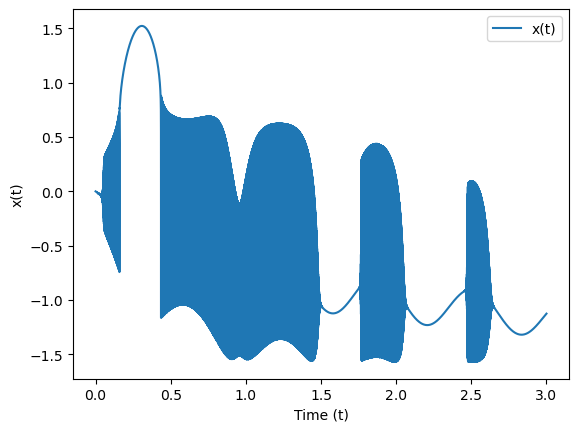

In [ ]:
# Define the system of equations
def system(z, t):
    x, y = z
    dxdt = y
    dydt = -alpha_t(t) * gamma ** 2 - beta_t(
        t) * gamma ** 2 * x - gamma ** 2 * x ** 3 - gamma * x ** 2 * y + gamma ** 2 * x ** 2 - gamma * x * y
    return [dxdt, dydt]


# Parameters
gamma = 10000.  #empirically chosen
alpha_t = lambda t: t * math.cos(.1 * t)
beta_t = lambda t: math.cos(10 * t)

# Initial conditions
x0 = 0.0  # Initial x value
y0 = 1.0  # Initial y value
z0 = [x0, y0]

# Time
time_length = 3
sr = 44100

# Time vector
t = np.linspace(0, time_length, sr * time_length)

# Solve the system
solution = odeint(system, z0, t)

# Extract the solutions
x = solution[:, 0]
y = solution[:, 1]

# Plot the results
# plt.plot(t, y, label='y(t)') #Hidden as it makes x almost invisible
plt.plot(t, x, label='x(t)')
plt.xlabel('Time (t)')
plt.ylabel('x(t)')
plt.legend()
plt.show()

Saving.  
Change name.  
x is multiplied as it's too low to produce hearable sound if not

In [ ]:
# wavf.write("test_nx.wav", sr, 1000*x.astype(np.int16))

Audio play

In [ ]:
display.Audio(x, rate=sr)

## Mel spectrogram and curve analysis

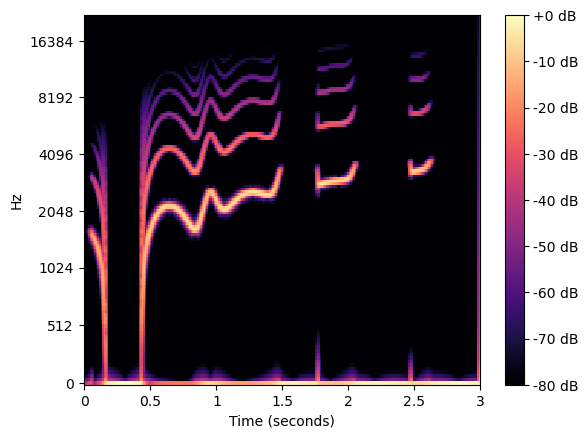

In [ ]:
#Calculate and show mel spectrogram
ps = librosa.feature.melspectrogram(y=x, sr=sr)  #mel
ps_db = librosa.power_to_db(ps, ref=np.max)  #power to db
librosa.display.specshow(ps_db, x_axis='s', y_axis='mel', sr=sr)  #shows
plt.colorbar(format="%+2.0f dB")  #colorbar

Show the different curves  
TODO : make graphs easier to read

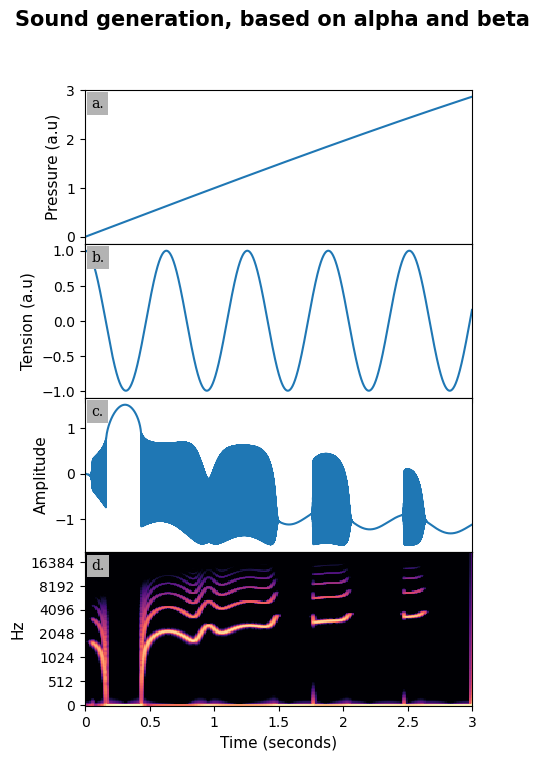

In [ ]:
#get alpha and beta curves
alpha_curve = [alpha_t(val) for val in t]
beta_curve = [beta_t(val) for val in t]

#generate subplots
fig = plt.figure(figsize=(5, 8))
gs = fig.add_gridspec(4,
                      hspace=0)  #hspace=0 to stick the plots together, makes it more readable regarding shared axis
axs = gs.subplots(sharex=True)  #sharex to share the x axis
fig.suptitle("Sound generation, based on alpha and beta", fontsize=15,
             fontweight="bold")

#Ploting
axs[0].plot(t, alpha_curve)
axs[0].set_label("a.")
axs[0].set_ylabel("Pressure (a.u)", fontsize="11")

axs[1].plot(t, beta_curve)
axs[1].set_label("b.")
axs[1].set_ylabel("Tension (a.u)", fontsize="11")

axs[2].plot(t, x)
axs[2].set_label("c.")
axs[2].set_ylabel("Amplitude", fontsize="11")

librosa.display.specshow(ps_db, x_axis='s', y_axis='mel', sr=sr)
axs[3].set_label("d.")
axs[3].set_ylabel("Hz", fontsize="11")
axs[3].set_xlabel("Time (seconds)", fontsize="11")

for ax in axs:
    ax.annotate(
        ax.get_label(),
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

a. Corresponds to $\alpha$  
b. Corresponds to $\beta$  
c. Corresponds to $x(t)$  
d. Corresponds to the mel spectrogram of $x(t)$

In [ ]:
#Save the plot as svg file
# plt.savefig("output/imgs/spectrogram_test_n6.svg", format="svg")

## $P_{in}$ calculation
$P_{in}(t)=x(t)\nu(t)-rP_{in}(t-T)$  
$\nu=\frac{\Delta x}{\Delta t}$

In [ ]:
#nu calculation, mean velocity
def nu(x, t):
    nu_t = np.zeros(len(x))
    delta_t = t[1] - t[0]  #time is based on linear space => Delta(t) is a constant
    for i in range(len(x) - 1):
        nu_t[i] = (x[i + 1] - x[i]) / delta_t
    return nu_t

In [ ]:
## P_in calculation
# x : input
# nu : mean velocity
# sr : sampling frequency, used to calculate delay
# T : delay (in seconds, arbitrarly chosen)
# r : reflection coefficient of the trachea (chosen arbitrarly so far)
def P_in_calculation(x, nu_t, sr, T=.01, r=.1):
    T_i = int(T * sr)
    output = x * nu_t
    for i in range(T_i, len(output)):
        output[i] = output[i] - r * output[i - T_i]
    return output

$P_{inpartial}$ is actually useless, and is just used to see how the curves evolve

In [ ]:
#pin partial calculation, based on nu
nu_t = nu(x, t)
p_in_partial = x * nu_t
p_in = P_in_calculation(x, nu_t, sr)

#spectrogram of p_in_partial
ps_pinp = librosa.feature.melspectrogram(y=p_in_partial, sr=sr)  #mel<
ps_db_pinp = librosa.power_to_db(ps_pinp, ref=np.max)  #power to db

#same for p_in
ps_pin = librosa.feature.melspectrogram(y=p_in, sr=sr)  #mel
ps_db_pin = librosa.power_to_db(ps_pin, ref=np.max)  #power to db

Text(0.5, 1.0, '$P_{in}(t)$ mel spectrogram')

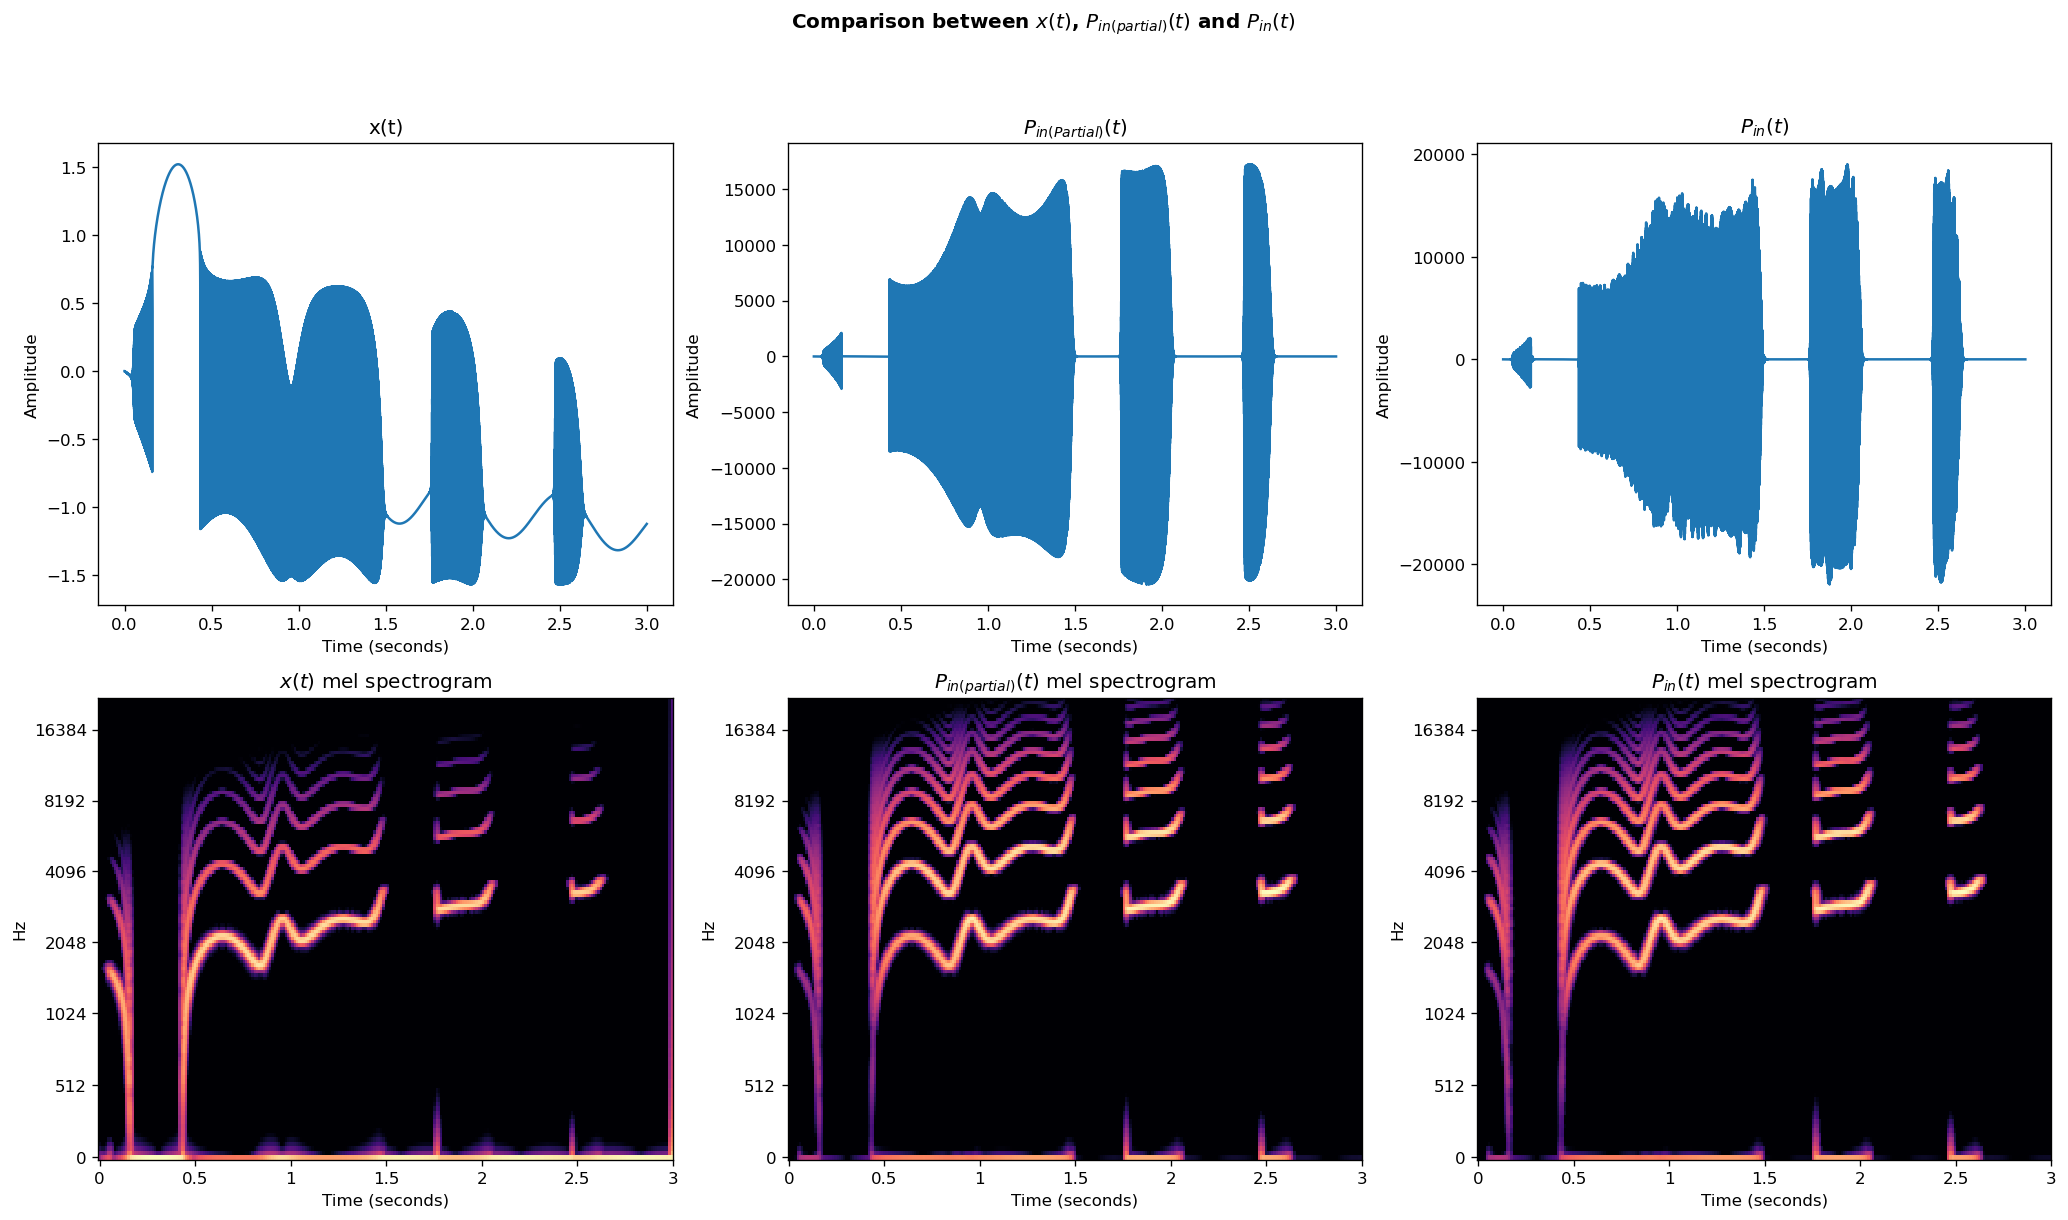

In [ ]:
# Show p_in partial and x with their mel spectrograms
fig, axs = plt.subplots(2, 3, figsize=(21, 11), dpi=120)
fig.suptitle("Comparison between $x(t)$, $P_{in(partial)}(t)$ and $P_{in}(t)$",
             fontweight="bold")
axs[0, 0].plot(t, x)
axs[0, 1].plot(t, p_in_partial)
axs[0, 2].plot(t, p_in)
librosa.display.specshow(ps_db, x_axis='s', y_axis='mel', sr=sr, ax=axs[1, 0])
librosa.display.specshow(ps_db_pinp, x_axis='s', y_axis='mel', sr=sr, ax=axs[1, 1])
librosa.display.specshow(ps_db_pin, x_axis='s', y_axis='mel', sr=sr, ax=axs[1, 2])

#Comments and stuff
axs[0, 0].set(
    title="x(t)",
    ylabel="Amplitude",
    xlabel="Time (seconds)"
)

axs[0, 1].set(
    title="$P_{in(Partial)}(t)$",
    ylabel="Amplitude",
    xlabel="Time (seconds)"
)

axs[0, 2].set(
    title="$P_{in}(t)$",
    ylabel="Amplitude",
    xlabel="Time (seconds)"
)

axs[1, 0].set_title("$x(t)$ mel spectrogram")
axs[1, 1].set_title("$P_{in(partial)}(t)$ mel spectrogram")
axs[1, 2].set_title("$P_{in}(t)$ mel spectrogram")

Save the sounds

In [ ]:
# wavf.write("test_nu.wav", sr, nu_t.astype(np.int16))
# wavf.write("test_pin.wav", sr, p_in.astype(np.int16))

Play the sound $P_{in}$

In [ ]:
display.Audio(p_in, rate=sr)

## $P_{out}$ calculation

In [ ]:
# Parameters for the Helmholtz resonator. !!! Parameters are SI !!!
v = 344  # Speed of sound in air (m/s)
A = 0.0016  # Cross-sectional area of the neck (m^2)
V = 0.000009425  # Volume of the cavity (m^3)
L = 0.03  # Length of the neck (m)

# Calculate the resonance frequency of the Helmholtz resonator
f0 = (v / (2 * np.pi)) * np.sqrt(A / (V * L))
print(f"Resonance Frequency: {f0:.2f} Hz")

Resonance Frequency: 4118.48 Hz


In [ ]:
# Create a band-pass filter around the resonance frequency
threshold = 300  # Arbitrary chosen, might need adjustments
lowcut = f0 - threshold  # Lower bound of the passband (Hz)
highcut = f0 + threshold  # Upper bound of the passband (Hz)
order = 4  # Filter order

# Design the band-pass filter
b, a = signal.butter(order, [lowcut, highcut], fs=sr, btype='band')

# Apply the filter to the sound wave
p_out = signal.filtfilt(b, a, p_in)

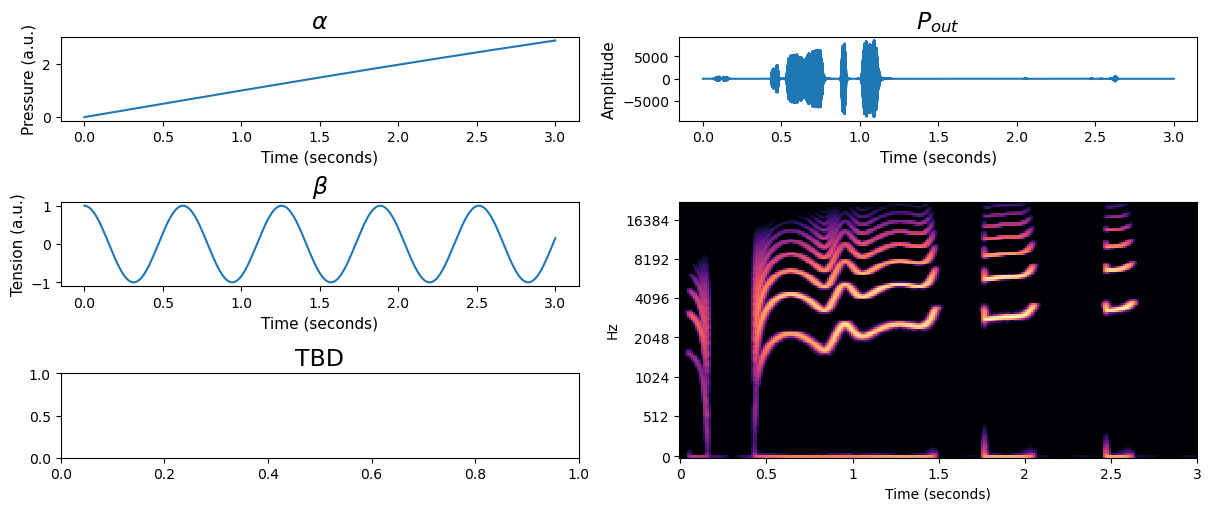

In [ ]:
fig = plt.figure(layout="constrained", figsize=(12, 5))
axs = fig.subplot_mosaic([["a.", "d."], ["b.", "e."], ["c.", "e."]])

#P_out mel spectrogram calculation
ps_pout = librosa.feature.melspectrogram(y=p_out, sr=sr)  #mel
ps_db_pout = librosa.power_to_db(ps_pout, ref=np.max)  #power to db

axs["a."].plot(t, alpha_curve)
axs["a."].set_title("$\\alpha$", fontsize=17)
axs["a."].set_xlabel("Time (seconds)", fontsize=11)
axs["a."].set_ylabel("Pressure (a.u.)", fontsize=11)

axs["b."].plot(t, beta_curve)
axs["b."].set_title("$\\beta$", fontsize=17)
axs["b."].set_xlabel("Time (seconds)", fontsize=11)
axs["b."].set_ylabel("Tension (a.u.)", fontsize=11)

axs["c."].set_title("TBD", fontsize=17)

axs["d."].plot(t, p_out)
axs["d."].set_title("$P_{out}$", fontsize=17)
axs["d."].set_xlabel("Time (seconds)", fontsize=11)
axs["d."].set_ylabel("Amplitude", fontsize=11)

librosa.display.specshow(ps_db_pin, x_axis='s', y_axis='mel', sr=sr, ax=axs["e."])

In [ ]:
# wavf.write("test_pout.wav", sr, p_out.astype(np.int16))

Play $P_{out}$

In [ ]:
display.Audio(p_out, rate=sr)